In [1]:
# !pip install pycocotools --quiet
# !git clone https://github.com/pytorch/vision.git
# !git checkout v0.3.0

# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

In [2]:
import os
import numpy as np
import torch as tc
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm, trange
import pickle

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
# import transforms as T
#import cv2
from WishDataSet import WishDataSet, get_transform
from wish_utils import *

In [3]:
tc.__version__

'2.2.1+cu118'

In [4]:
tc.cuda.is_available(), tc.cuda.device_count()

(True, 2)

In [5]:
!nvidia-smi

Mon Feb 26 14:11:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 4000                Off | 00000000:00:05.0 Off |                  N/A |
| 30%   35C    P8              13W / 125W |    241MiB /  8192MiB |     18%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
tc.cuda.current_device(), tc.cuda.device(0), tc.cuda.get_device_name()

(0, <torch.cuda.device at 0x7f1c17031ea0>, 'Quadro RTX 4000')

In [7]:
# f = "/home/wj1132075/Desktop/CNN_Model_Data/Annotations/annot_56_25.pickle"
# with open(f, 'rb') as handle:
#     annot_dict = pickle.load(handle)
#     bin_data = np.load(annot_dict['nparr_path'])['arr_0']
#     # img_res = np.tile(bin_data[:,:,None], 3)
#     bin_data = cv2.normalize(bin_data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
#     # img_res = cv2.resize(img_res, (128, 128), cv2.INTER_AREA)

In [8]:
# bin_data.shape

In [9]:
# np.max(bin_data), np.min(bin_data)

In [10]:
# cv2.imshow('let see', bin_data)
# cv2.waitKey(0)
# cv2.destroyAllWindoes()

In [11]:
# img_res = cv2.resize(img_res, (128, 128), cv2.INTER_AREA)

In [12]:
annotations_dir = "/home/wj1132075/Desktop/CNN_Model_Data/Annotations/"
ds = WishDataSet(annotations_dir)
len(ds)

4065

In [13]:
im, tar = ds[0]
type(im), type(tar)

(numpy.ndarray, dict)

In [14]:
im.shape

(1520, 128, 3)

In [15]:
tar

{'boxes': tensor([[ 0., 55.,  4., 75.]]),
 'labels': tensor([1]),
 'area': tensor([80.]),
 'iscrowd': tensor([0]),
 'image_id': 0}

In [16]:
# t = A.Compose([
#                A.augmentations.geometric.resize.Resize(128, 128, p=1),
#                A.HorizontalFlip(0.5),
#                ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [17]:
# new = t(image = im, bboxes = tar['boxes'], labels = tar['labels'])
# new

In [18]:
# new['image'].shape

In [19]:
# transform = A.Compose(
#     [        
#         A.augmentations.geometric.resize.Resize(128, 128, p=1),
#         # A.VerticalFlip(p=0.5), 
#         ToTensorV2(p=1.0)
#     ],
#     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
# )

In [20]:
# transform = A.Compose(
#     [       
#         A.VerticalFlip(0.5),
#         A.augmentations.geometric.resize.Resize(128, 128, p=1),
#         ToTensorV2(p=1.0)
#     ], 
#     bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# for i in trange(5):
#     new = transform(image = im, bboxes = tar['boxes'], labels = tar['labels'])
#     print(new['bboxes'])
#     plot_bin(new['image'][0,...], new['bboxes'], 0)

In [21]:
# plot_img_bbox(im, tar)

### See bins and boxes

In [22]:
# i=0
# for (im, tar) in ds:
#     plot_bin(im[:,:,0], tar['boxes'], i)
#     i+=1
#     if i == 5:
#         break

### Calculate the stats

In [23]:
# dl = tc.utils.data.DataLoader(ds, batch_size=100, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)
# stats = get_stats(dl)
# stats

In [24]:
# stats = (np.array([1.26653515, 1.26653515, 1.26653515]), np.array([4.59509826, 4.59509826, 4.59509826]))
# stats

### Training and test data sets

In [25]:
# use our dataset and defined transformations
stats=None
dataset = WishDataSet(annotations_dir, transforms=get_transform(train=True, stats=stats))
dataset_test = WishDataSet(annotations_dir, transforms=get_transform(train=False, stats=stats))

In [26]:
# a,b=dataset[800]

In [27]:
# a.shape

In [28]:
# b

In [29]:
# split the dataset in train and test set
tc.manual_seed(1)
indices = tc.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = tc.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = tc.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = tc.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
data_loader_test = tc.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

### Model Training

In [30]:
# to train on gpu if selected.
device = tc.device('cuda') if tc.cuda.is_available() else tc.device('cpu')

num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes, pretrained=False)

/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Data Parallel

In [31]:
# model = tc.nn.DataParallel(model, device_ids=[0,1])

In [32]:
freeze_to(model, False)

In [33]:
device

device(type='cuda')

In [34]:
[p.requires_grad for p in model.parameters()]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [35]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = tc.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = tc.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=3,
                                            gamma=0.1)# to train on gpu if selected.

In [36]:
len(params)

72

In [37]:
lr_scheduler

### Training 

In [38]:
num_epochs = 20
for epoch in trange(num_epochs):
    # training for one epoch
    print(f"starting epoch {epoch}")
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

starting epoch 0
Epoch: [0]  [  0/407]  eta: 0:07:29  lr: 0.000017  loss: 7.9068 (7.9068)  loss_classifier: 0.4357 (0.4357)  loss_box_reg: 0.1319 (0.1319)  loss_objectness: 1.0066 (1.0066)  loss_rpn_box_reg: 6.3326 (6.3326)  time: 1.1043  data: 0.2545  max mem: 2127
Epoch: [0]  [ 50/407]  eta: 0:02:33  lr: 0.000632  loss: 0.9458 (2.3689)  loss_classifier: 0.0313 (0.1358)  loss_box_reg: 0.0300 (0.0448)  loss_objectness: 0.5032 (0.5982)  loss_rpn_box_reg: 0.4206 (1.5900)  time: 0.4089  data: 0.0232  max mem: 2325
Epoch: [0]  [100/407]  eta: 0:02:11  lr: 0.001248  loss: 0.4872 (1.4827)  loss_classifier: 0.0110 (0.0778)  loss_box_reg: 0.0475 (0.0511)  loss_objectness: 0.1185 (0.3834)  loss_rpn_box_reg: 0.3183 (0.9704)  time: 0.4339  data: 0.0233  max mem: 2325
Epoch: [0]  [150/407]  eta: 0:01:51  lr: 0.001863  loss: 0.3418 (1.1381)  loss_classifier: 0.0083 (0.0550)  loss_box_reg: 0.0181 (0.0428)  loss_objectness: 0.0475 (0.2852)  loss_rpn_box_reg: 0.2457 (0.7552)  time: 0.4433  data: 0.022

#### Save the trained model

In [39]:
model_save_path = '/mnt/ceph/home/wj1132075/Desktop/CNN_Model_Data/fasterrcnn_resnet50_fpn_trained_from_beginning.pt'

In [40]:
tc.save(model.state_dict(), model_save_path)

In [41]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with tc.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  2
real #boxes:  1


In [42]:
prediction

{'boxes': tensor([[  91.8619, 1164.8572,   95.9106, 1184.7878],
         [  16.0818, 1159.8302,   19.7514, 1179.4700]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9607, 0.9529], device='cuda:0')}

In [43]:
target

{'boxes': tensor([[  92., 1163.,   96., 1183.]]),
 'labels': tensor([1]),
 'area': tensor([80.]),
 'iscrowd': tensor([0]),
 'image_id': 1164}

In [44]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[  91.8619, 1164.8572,   95.9106, 1184.7878],
         [  16.0818, 1159.8302,   19.7514, 1179.4700]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9607, 0.9529], device='cuda:0')}

In [45]:
img.shape

torch.Size([3, 1520, 128])

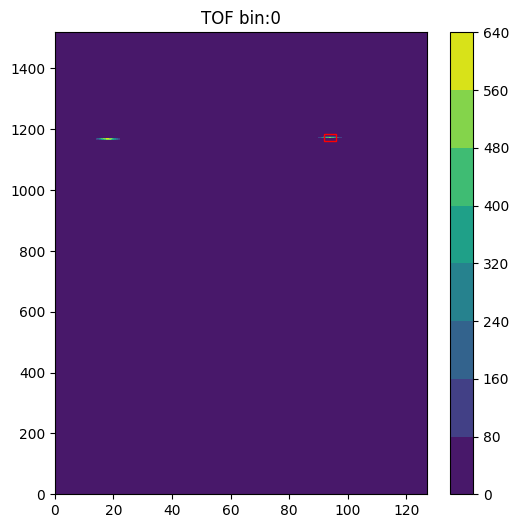

In [46]:
plot_bin(img[0,:,:], target['boxes'], 0)

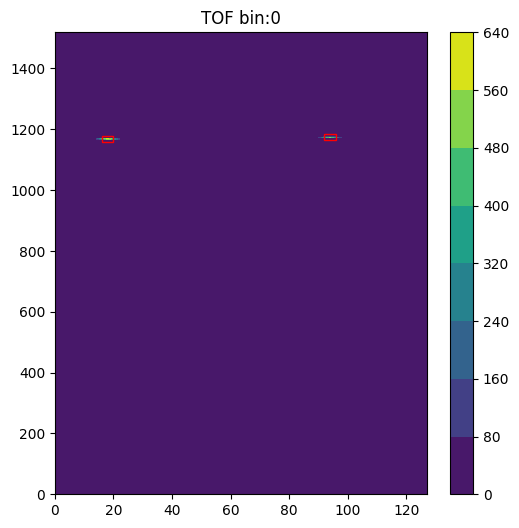

In [47]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

### Load the model from disk

In [48]:
r_model = get_object_detection_model(num_classes)
# r_model.load_state_dict(tc.load(model_save_path))
r_model.load_state_dict(tc.load(model_save_path, map_location=tc.device('cpu')))
r_model = r_model.to(device)

/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
img, target = dataset_test[100]
r_model.eval()
with tc.no_grad():
    prediction = r_model([img.to(device)])[0]
prediction

{'boxes': tensor([[101.0581, 530.6974, 104.5550, 550.7758]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9593], device='cuda:0')}

In [50]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[101.0581, 530.6974, 104.5550, 550.7758]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9593], device='cuda:0')}

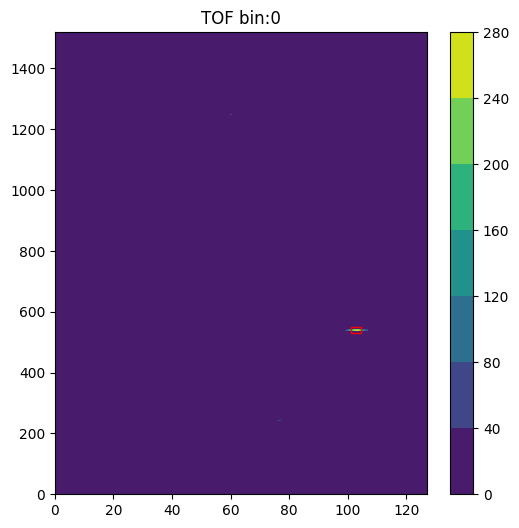

In [51]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

{'boxes': tensor([[ 104.9527, 1249.8673,  108.8800, 1270.0131],
        [   3.3800, 1256.7267,    7.3418, 1276.8212]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9763, 0.5133], device='cuda:0')}
{'boxes': tensor([[ 104.9527, 1249.8673,  108.8800, 1270.0131],
        [   3.3800, 1256.7267,    7.3418, 1276.8212]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9763, 0.5133], device='cuda:0')}


IndexError: too many indices for tensor of dimension 2

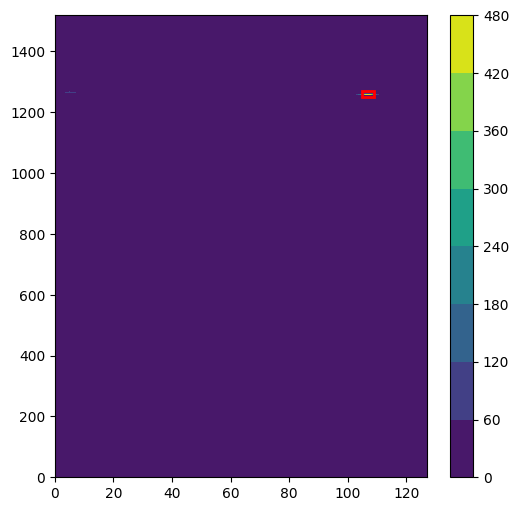

In [52]:
r_model.eval()
probe = 0
for img, target in data_loader_test:
    imgs = list(img)
    targets = list(target)
    with tc.no_grad():
        for img, target in zip(imgs, targets):
            prediction = r_model([img.to(device)])[0]
            print(prediction)
            nms_prediction = apply_nms(prediction, iou_thresh=0.001)
            print(nms_prediction)
            plot_bin_detections(img[0,:,:], target['boxes'], nms_prediction)
            probe += 1

    if probe == 1:
        break

In [ ]:
for a,b in data_loader_test:
    a = list(a)
    b = list(b)
    print(a)
    print(b)
    break